# SD212: Graph mining

## Project

### Title: How can we make good recommendations to a fellow anime watcher?

### Students: CHHY Laurent, MAI Huu Tan

The objective of this project is to learn how to extract useful information from graph data. 

Your task is the following:
* build your own graph from real data
* specify the problem(s) you would like to solve
* provide a solution
* visualize the results

## Instructions

You can work in **teams of 2 or 3**.

Fill the following variable with the names of all students of this project separated by _:

In [1]:
name = 'CHHY_MAI'

You **must** use this name for the pickle file of your dataset and provide a link to this file:

In [2]:
# url to your dataset, to be modified
url = 'https://nextcloud.r2.enst.fr/nextcloud/index.php/s/EqaGnAeSYC38ZHW'

Check the notebook ``my_dataset`` to generate a pickle file in appropriate format (``Bunch`` object).

You must use the following name for your notebook:

In [3]:
# name of your notebook
name + '.ipynb'

'CHHY_MAI.ipynb'

## Data

In [4]:
import pickle

In [5]:
# you need to download data first (see the above url)
with open(name, 'br') as f:
    dataset = pickle.load(f)

In [6]:
dataset

{'anime_df':      anime_id                                            name  \
 0        5114             b'Fullmetal Alchemist: Brotherhood'   
 1       28977                              b'Gintama\xc2\xb0'   
 2        9253                                  b'Steins;Gate'   
 3       38524           b'Shingeki no Kyojin Season 3 Part 2'   
 4        9969                                     b"Gintama'"   
 ..        ...                                             ...   
 195      9617                                  b'K-On! Movie'   
 196     17389                           b'Kingdom 2nd Season'   
 197     22535                   b'Kiseijuu: Sei no Kakuritsu'   
 198     49909                     b'Kotarou wa Hitorigurashi'   
 199     37515  b'Made in Abyss Movie 2: Hourou Suru Tasogare'   
 
                                                  genre   type  episodes  \
 0          ['Action', 'Adventure', 'Drama', 'Fantasy']     TV      64.0   
 1                       ['Action', 'Comed

Describe your data and how it has been collected (do not include the code used to extract data).

The data consists of:
- Information about the top 200 anime in MyAnimeList
- The user updates about those anime

It was obtained by first doing requests to the API of MyAnimeList (see [here](https://myanimelist.net/apiconfig/references/api/v2#operation/anime_ranking_get) for the documentation), which allowed us to extract the ID of the anime in question.
Secondly, we used the Jikan API (see [here](https://jikan.docs.apiary.io/#reference/0/anime) for the documentation) to obtain the anime information and the user updates (which included ratings).
After collecting the cleaned responses in JSON format, we parsed those files to create csv files.

## Problem

The problem we want to solve is that of recommendations. The question is as follows:
How can we make good recommendations to a fellow anime watcher?

## Solution


### Imports


In [7]:
import numpy as np

from sknetwork.data import from_edge_list
from sknetwork.visualization import svg_graph, svg_bigraph, svg_dendrogram
from sknetwork.ranking import PageRank, top_k
from sknetwork.embedding import Spectral
from sknetwork.utils import get_neighbors, WardDense
from sknetwork.hierarchy import Paris



import csv
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG

### Preprocessing

Now that we retrieved the dataset, we can clean the data a little in order to build a graph from it.

We start with the top 200 anime information.

In [8]:
# Retrieving the top 200 anime information as a Pandas DataFrame.

anime_df = dataset.anime_df
anime_df["name"][0]

"b'Fullmetal Alchemist: Brotherhood'"

The titles are written incorrectly. We need to rewrite the titles.

In [9]:
def rewrite_title(title):
    return title[2:-1]

anime_df["name"] = anime_df["name"].apply(rewrite_title)

anime_df

,anime_id,name,genre,type,episodes,rating,members
0,5114,Fullmetal Alchemist: Brotherhood,"['Action', 'Adventure', 'Drama', 'Fantasy']",TV,64.0,9.14,2893493
1,28977,Gintama\xc2\xb0,"['Action', 'Comedy', 'Sci-Fi']",TV,51.0,9.08,536990
2,9253,Steins;Gate,"['Drama', 'Sci-Fi', 'Suspense']",TV,24.0,9.08,2245646
3,38524,Shingeki no Kyojin Season 3 Part 2,"['Action', 'Drama']",TV,10.0,9.07,1847582
4,9969,Gintama',"['Action', 'Comedy', 'Sci-Fi']",TV,51.0,9.05,473413
...,...,...,...,...,...,...,...
195,9617,K-On! Movie,"['Comedy', 'Slice of Life']",Movie,1.0,8.35,294502
196,17389,Kingdom 2nd Season,['Action'],TV,39.0,8.35,103013
197,22535,Kiseijuu: Sei no Kakuritsu,"['Action', 'Horror', 'Sci-Fi']",TV,24.0,8.35,1636938
198,49909,Kotarou wa Hitorigurashi,"['Comedy', 'Slice of Life']",ONA,10.0,8.34,76773


Next, we can look at the dataset that contains the recent user ratings of those anime.

In [10]:
rating_df = dataset.rating_df
rating_df

,username,anime_id,rating
0,Lachawla,1,-1
1,Dubba,1,9
2,epicene,1,10
3,Effloress,1,-1
4,JeSuisGarrick,1,-1
...,...,...,...
74395,bxrrylatte,9969,-1
74396,KarolusZan,9969,-1
74397,bilwor,9969,-1
74398,JezusAntychryst,9969,-1


We can check whether or not all of those anime have been rated.

In [11]:
def check_sanity():
    L1 = set(rating_df['anime_id'])
    L2 = set(anime_df['anime_id'])
    print(len(L1))
    print(len(L2))
    for x in L2:
        if x not in L1:
            print(x)

check_sanity()

199
200
44042


It turns out that one of the animes has no ratings. This is a problem with the Jikan API used to scrape user updates, but we will choose to deliberately ignore that.

In [12]:
# The -1 in the ratings mean that the user has not rated the anime.
rating_df = rating_df[rating_df['rating'] >0]

We can plot the ratings to have an idea of the rating distribution.

Text(0.5, 1.0, 'Rating Distribution')

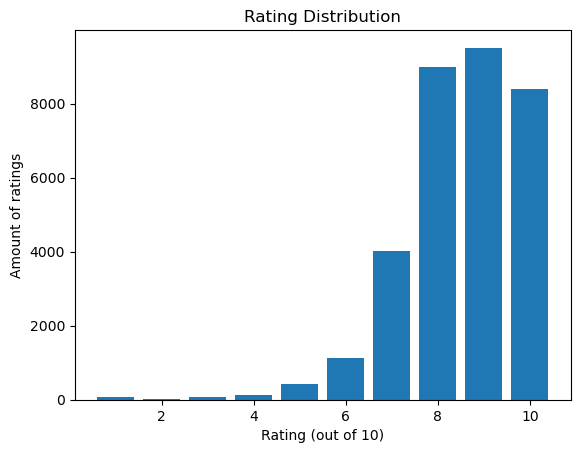

In [13]:
from collections import Counter

#count ratings
rating_count = Counter(rating_df['rating'])
#plot ratings
plt.bar(rating_count.keys(), rating_count.values())
plt.xlabel("Rating (out of 10)")
plt.ylabel("Amount of ratings")
plt.title("Rating Distribution")

As expected, because the anime data scraped were from the top 100 from MyAnimeList, many of the ratings are very high.

Since the genres are incorrectly input as a string, we will parse the string to extract the genres of each anime as a list.

In [14]:
rating_numpy = rating_df.to_numpy()

In [15]:
def parse_list_str(str):
    list = str[1:-1].replace("'", "").split(",")
    for i in range(len(list)):
        list[i] = list[i].strip()
    return list
parse_list_str(anime_df["genre"][0])

['Action', 'Adventure', 'Drama', 'Fantasy']

In [16]:
anime_ids = np.unique(rating_numpy[:, 1])
#retrieve anime names from anime_df
anime_names = []
anime_genres = []
for anime_id in anime_ids:
    name = anime_df[anime_df['anime_id'] == anime_id]['name'].values
    genre_str = anime_df[anime_df['anime_id'] == anime_id]['genre'].values
    genre_list = parse_list_str(genre_str[0])
    anime_genres.append(genre_list)
    anime_names.append(name[0])
anime_names = np.array(anime_names)
anime_genres = np.array(anime_genres, dtype=object)

In [17]:
# For example, the genres of Cowboy Bebop are Action, Sci-Fi.
anime_genres[anime_names=="Cowboy Bebop"]

array([list(['Action', 'Sci-Fi'])], dtype=object)

Then, we can one-hot-encode those genres to facilitate the graph mining methods later.

In [18]:
#one_hot_encode genres
def one_hot_genres(anime_genres):
    all_genres = np.unique(np.concatenate(anime_genres))
    one_hot_genres = []
    for genre_list in anime_genres:
        one_hot_genre = np.zeros(len(all_genres))
        for genre in genre_list:
            one_hot_genre[all_genres == genre] = 1
        one_hot_genres.append(one_hot_genre)
    return np.array(one_hot_genres), all_genres

Finally, to have the animes on the left side and the users on the right side of the bipartite graph, we can swap the columns.

In [19]:
# swapping columns to have the anime_id as the first column
rating_numpy = rating_numpy[:, [1, 0, 2]]

Now is a good time to build the graph.

In [20]:
# Now we build the graph
graph = from_edge_list(rating_numpy,bipartite = True)

In [21]:
biadjacency = graph.biadjacency
names = np.array(anime_names)
labels, label_names = one_hot_genres(anime_genres)

In [22]:
biadjacency

<199x16835 sparse matrix of type '<class 'numpy.intc'>'
	with 32043 stored elements in Compressed Sparse Row format>

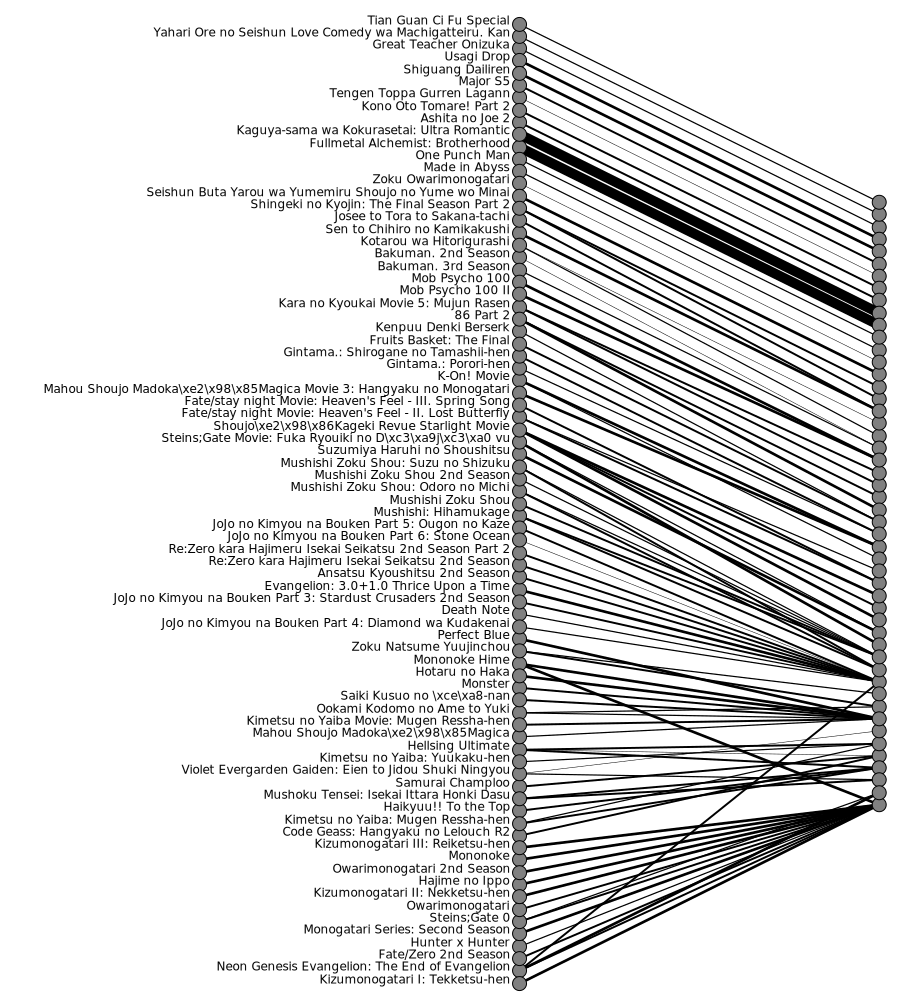

In [23]:
# For better visibility, we only view the ratings of the first max_visu_users=50 users.

# We pick a good seed for visualization.
rng = np.random.RandomState(seed=5)

max_visu_users = 50
visualization_index = rng.choice(biadjacency.shape[1], size=max_visu_users, replace=False)

# Retrieve the animes rated by the users with a mask
truncated_biadjacency = biadjacency[:, visualization_index]
mask = np.sum(truncated_biadjacency, axis=1) > 0
mask = np.array(mask).flatten()

image = svg_bigraph(truncated_biadjacency[mask], names[mask], height=800, width = 300, scale = 1.2)
SVG(image)

The popular animes are the ones with many incoming vertices. The users, represented by the nodes on the right side, are made anonymous (their username has no relevance here).

In [24]:
biadjacency.shape

(199, 16835)

## Pagerank

We can attempt to use personalized PageRank to get the most popular movies of each genre.

Since we already have the top animes in order in the dataframe, we can see if they match the prediction given by a PageRank.

In [25]:
pagerank = PageRank()

In [26]:
# Get the good positive ratings.
positive = biadjacency >= 1

In [27]:
# Top 20 animes according to pagerank
scores = pagerank.fit_transform(positive)
names[top_k(scores, 20)]

array(['Kimetsu no Yaiba Movie: Mugen Ressha-hen', 'Koe no Katachi',
       'Sen to Chihiro no Kamikakushi', 'Howl no Ugoku Shiro',
       'Violet Evergarden Gaiden: Eien to Jidou Shuki Ningyou',
       'Yakusoku no Neverland', 'Kimi no Na wa.', 'Shingeki no Kyojin',
       'One Punch Man', 'Shingeki no Kyojin Season 3',
       'Shingeki no Kyojin: The Final Season Part 2',
       'Shingeki no Kyojin Season 2',
       'Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou',
       'Death Note', 'Evangelion: 3.0+1.0 Thrice Upon a Time',
       'Mononoke Hime',
       'Steins;Gate Movie: Fuka Ryouiki no D\\xc3\\xa9j\\xc3\\xa0 vu',
       'Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai',
       'Neon Genesis Evangelion: The End of Evangelion',
       'Made in Abyss Movie 3: Fukaki Tamashii no Reimei'], dtype='<U69')

In [28]:
anime_df[:10]

,anime_id,name,genre,type,episodes,rating,members
0,5114,Fullmetal Alchemist: Brotherhood,"['Action', 'Adventure', 'Drama', 'Fantasy']",TV,64.0,9.14,2893493
1,28977,Gintama\xc2\xb0,"['Action', 'Comedy', 'Sci-Fi']",TV,51.0,9.08,536990
2,9253,Steins;Gate,"['Drama', 'Sci-Fi', 'Suspense']",TV,24.0,9.08,2245646
3,38524,Shingeki no Kyojin Season 3 Part 2,"['Action', 'Drama']",TV,10.0,9.07,1847582
4,9969,Gintama',"['Action', 'Comedy', 'Sci-Fi']",TV,51.0,9.05,473413
5,39486,Gintama: The Final,"['Action', 'Comedy', 'Drama', 'Sci-Fi']",Movie,1.0,9.05,103872
6,11061,Hunter x Hunter (2011),"['Action', 'Adventure', 'Fantasy']",TV,148.0,9.05,2382619
7,15417,Gintama': Enchousen,"['Action', 'Comedy', 'Sci-Fi']",TV,13.0,9.04,282329
8,42938,Fruits Basket: The Final,"['Drama', 'Romance', 'Supernatural']",TV,13.0,9.03,350828
9,820,Ginga Eiyuu Densetsu,"['Drama', 'Sci-Fi']",OVA,110.0,9.03,280661


The top ranking doesn't match at all.

This can be explained by the fact that while the rating entries were sampled from recent entries (June 2022), many of the top animes are rather old.

In [29]:
# number of animes per genre
n_selection = 10

# Top 10 animes for each genre
# selection using pagerank
selection = []
for label in np.arange(len(label_names)):
    ppr = pagerank.fit_transform(positive, seeds=labels[:, label])
    scores = ppr * labels[:, label]
    selection.append(top_k(scores, n_selection))
selection = np.array(selection)

# Then, we print our results.
for label, name_label in enumerate(label_names):
    print('---')
    print(label, name_label)
    # Sometimes the amount of animes of the specified genres is less than n_selection.
    p = len(anime_df[anime_df["genre"].str.contains(name_label)])
    n = np.minimum(n_selection, p)
    
    print(names[selection[label, :n]])

---
0 
['Paripi Koumei' 'Shoujo\\xe2\\x98\\x86Kageki Revue Starlight Movie'
 'Yoru ni Kakeru' 'Kizumonogatari I: Tekketsu-hen'
 'Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou'
 'Saenai Heroine no Sodatekata Fine' 'Zoku Owarimonogatari'
 'Mob Psycho 100' 'Grand Blue' 'Mo Dao Zu Shi']
---
1 Action
['One Piece' 'Wu Liuqi Zhi Xuanwu Guo Pian'
 'Gintama Movie 1: Shinyaku Benizakura-hen' 'Kingdom 3rd Season'
 'Shingeki no Kyojin: The Final Season Part 2' 'Gintama: The Semi-Final'
 'Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare'
 'Kingdom 2nd Season' 'Gintama' 'Gintama: The Final']
---
2 Adventure
['One Piece' 'Wu Liuqi Zhi Xuanwu Guo Pian'
 'Made in Abyss Movie 3: Fukaki Tamashii no Reimei'
 'Mushishi Zoku Shou: Odoro no Michi'
 'Made in Abyss Movie 2: Hourou Suru Tasogare'
 'Kaze no Tani no Nausica\\xc3\\xa4' 'Mushishi: Hihamukage'
 'Tian Guan Ci Fu' 'Mushishi Zoku Shou: Suzu no Shizuku' 'Ousama Ranking']
---
3 Avant Garde
['Perfect Blue' 'Neon Genesis Evangelion: The E

## Paris's algorithm

Now, we can recommend new animes by either presenting shows similar to one anime in particular or by taking into account what a user has already rated. Let's try the two methods.

To start the Paris algorithm, we attempt to use a specific anime as a seed. The one we choose is Kono Subarashii Sekai ni Shukufuku wo! (or for short, Konosuba), which is a comedy anime.

In [30]:
target = {id: name for id,name in enumerate(names) if "Kono Subarashii Sekai ni Shukufuku wo!" in name}
target

{144: 'Kono Subarashii Sekai ni Shukufuku wo! Movie: Kurenai Densetsu'}

In [31]:
scores_ppr = pagerank.fit_transform(positive, seeds={144:1})

In [32]:
names[top_k(scores_ppr - scores,10)]

array(['Kono Subarashii Sekai ni Shukufuku wo! Movie: Kurenai Densetsu',
       'Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai',
       'Nichijou', 'Made in Abyss Movie 3: Fukaki Tamashii no Reimei',
       'Violet Evergarden Movie', 'Fate/Zero 2nd Season',
       "Fate/stay night Movie: Heaven's Feel - II. Lost Butterfly",
       'Great Teacher Onizuka', 'Saiki Kusuo no \\xce\\xa8-nan 2',
       'Koe no Katachi'], dtype='<U69')

In [33]:
targets = get_neighbors(positive, 75, transpose = True)

In [34]:
names[targets][:10]

array(['Cowboy Bebop', 'Howl no Ugoku Shiro', 'Shigatsu wa Kimi no Uso',
       'Koe no Katachi', 'Ansatsu Kyoushitsu 2nd Season',
       '3-gatsu no Lion', 'Saiki Kusuo no \\xce\\xa8-nan',
       'Violet Evergarden', 'Yakusoku no Neverland',
       'Fruits Basket 2nd Season'], dtype='<U69')

In [35]:
mask = np.zeros(len(names),dtype='bool')
mask[targets] = 1

In [36]:
scores_ppr = pagerank.fit_transform(positive, seeds=mask)

In [37]:
names[top_k((scores_ppr - scores)*(1-mask),10)]

array(['Kimi no Na wa.', 'Sen to Chihiro no Kamikakushi',
       'Shingeki no Kyojin Season 3', 'One Punch Man',
       'Shingeki no Kyojin Season 2', 'Shingeki no Kyojin',
       'Saiki Kusuo no \\xce\\xa8-nan 2', 'Kimetsu no Yaiba',
       'Shingeki no Kyojin Season 3 Part 2',
       'Violet Evergarden Gaiden: Eien to Jidou Shuki Ningyou'],
      dtype='<U69')

In this list of recommendation we can see that 'Shingeki no Kyojin' is recommended multiple times because it has different seasons. This makes sense because we can assume that multiple season of an anime are somewhat similar.

Let's check this by using Paris's algorithm to compute a dendrogram.


In [38]:
paris = Paris()

In [39]:
animes = graph.names_row
users = graph.names_col

In [40]:
paris.fit(biadjacency)


Paris(weights='degree', reorder=True)

In [41]:
dendrogram_row = paris.dendrogram_row_
dendrogram_col = paris.dendrogram_col_

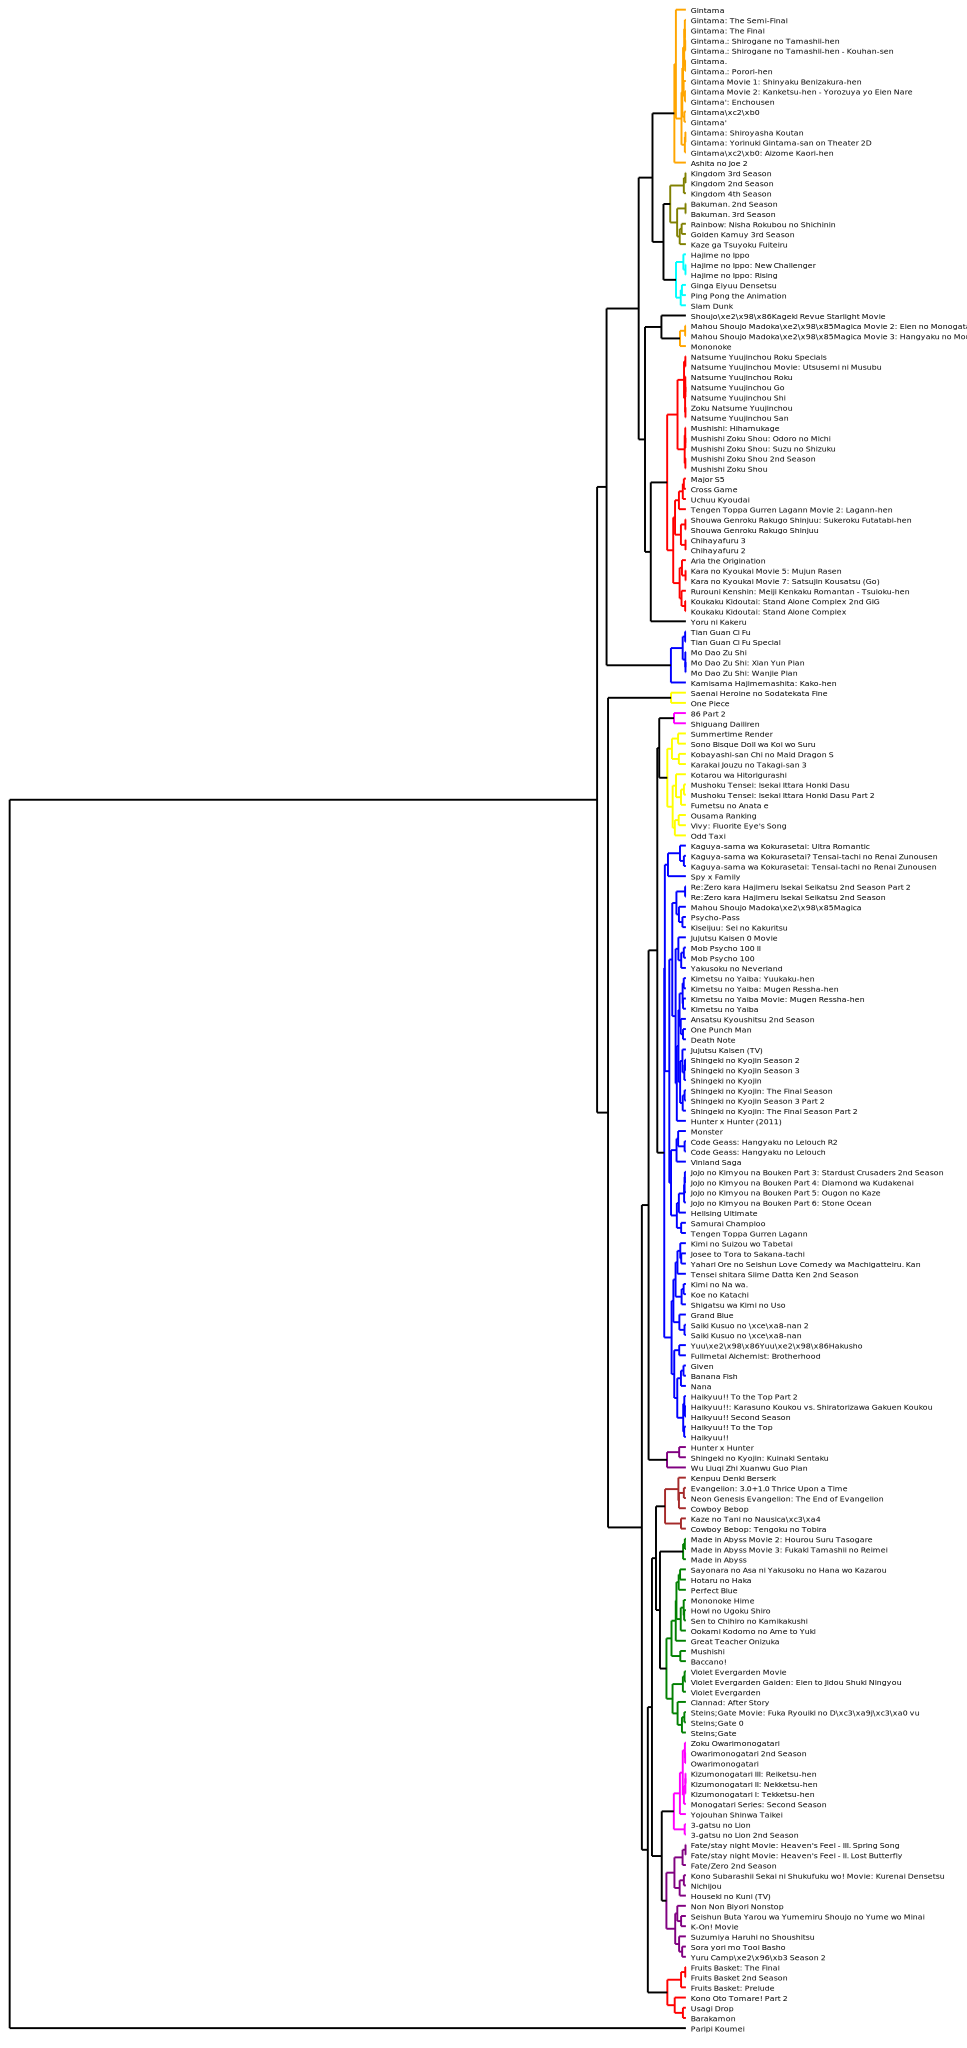

In [42]:
image = svg_dendrogram(dendrogram_row, names, rotate = True, width = 200, height=600, scale = 3.5, n_clusters = 20, font_size=8)
SVG(image)

Here we can see that animes that have multiple seasons (for example JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season, JoJo no Kimyou na Bouken Part 4: Diamond wa Kudakenai, JoJo no Kimyou na Bouken Part 5: Ougon no Kaze, JoJo no Kimyou na Bouken Part 6: Stone Ocean) are very close from each others in the clustering.

On an analysis standpoint, this classification shows that audiences are generally less concerned about genre when evaluating the quality of an anime, especially when it comes to the top anime. The clustering shows that they tend to watch sequels - or at least, anime of the same franchise, rather than selecting by genres.

Nevertheless, some animes are still grouped as belonging to the same genre. For example, Slam Dunk (basketball anime), Hajime no Ippo (boxing anime) and Ping Pong the Animation (table tennis anime) are in the same cluster.

We can then base our recommendation with the closest anime in the dendrogram. For instance, after a viewer watches the anime of the Kaguya-sama wa Kokurasetai franchise, one can recommend Spy x Family to them.

## Spectral embedding

We can try to classify using spectral embedding to confirm or not that we reach the same conclusions.

We turn each anime into a low dimension vector, then use hierarchical clustering to visualize the embedding.

In [43]:
spectral = Spectral(10)
embedding = spectral.fit_transform(positive)

In [44]:
ward = WardDense()
index = top_k(scores_ppr, 199)
dendrogram = ward.fit_transform(embedding[index])

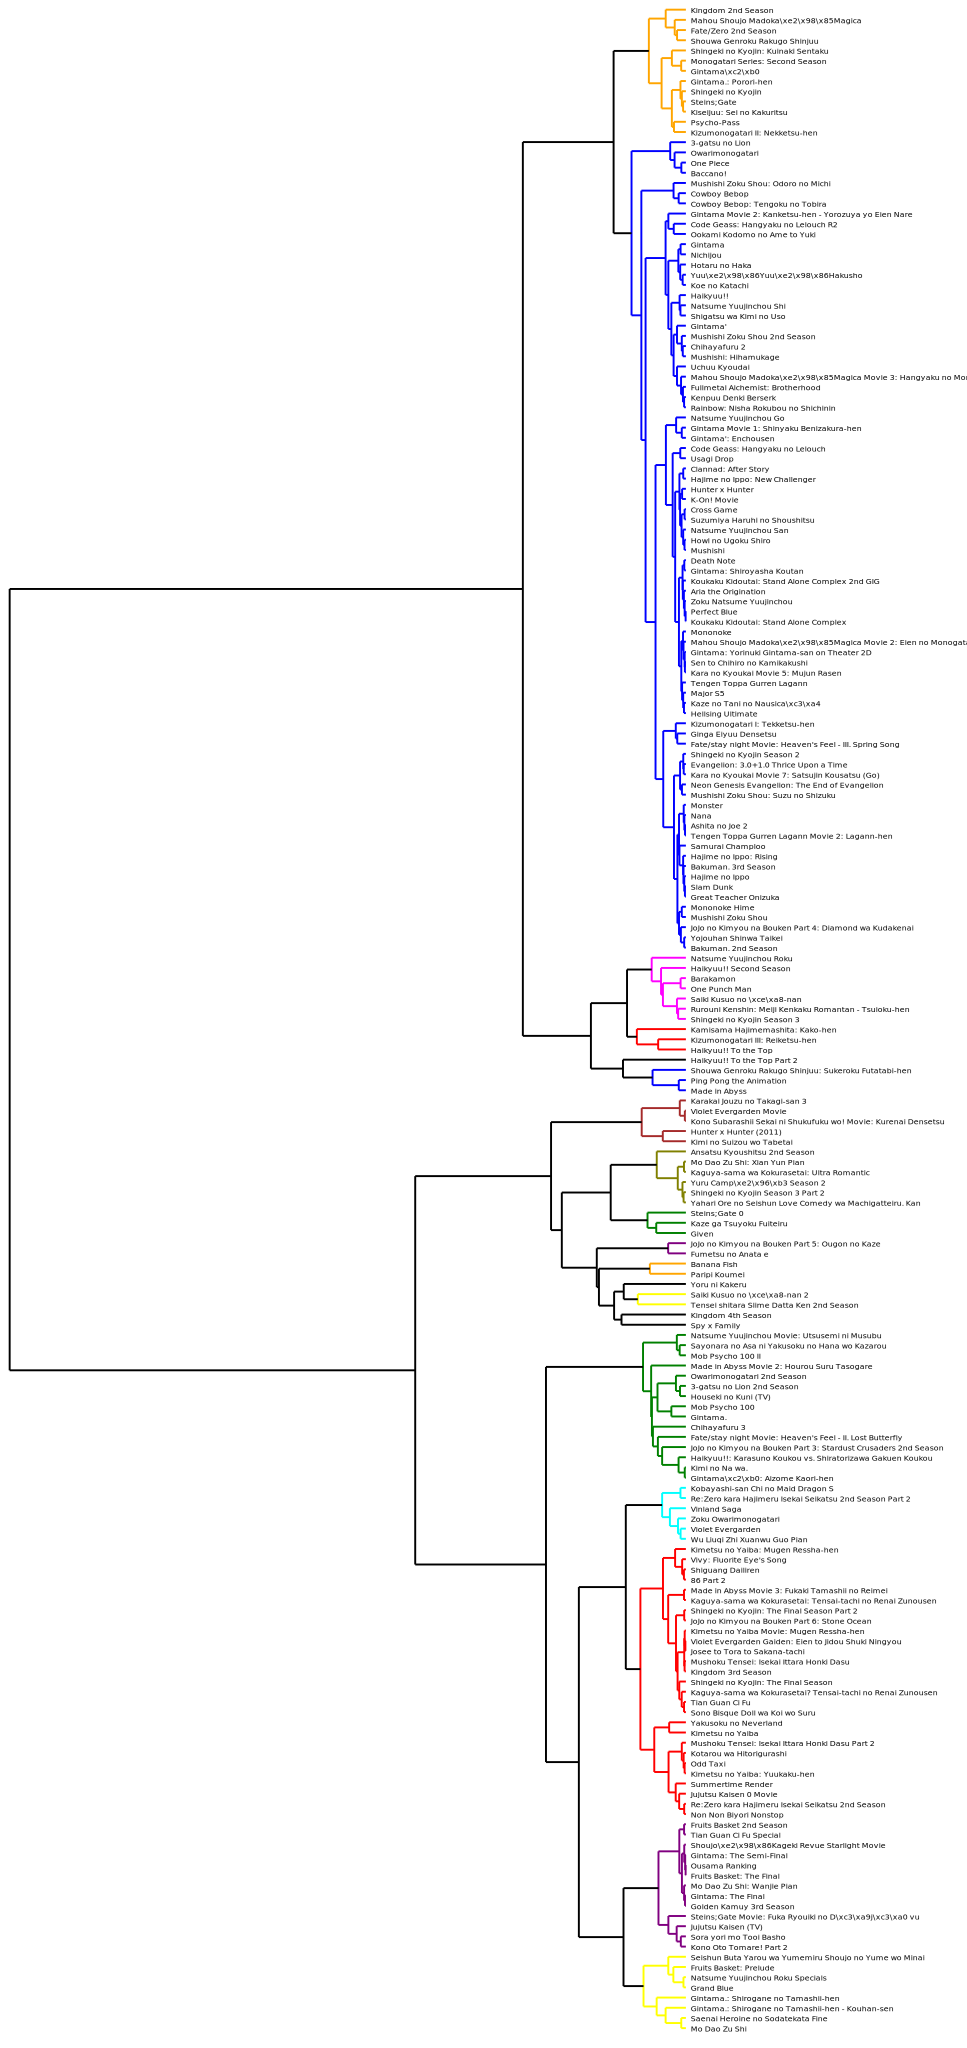

In [45]:
image = svg_dendrogram(dendrogram, names, rotate = True, width = 200, height=600, scale = 3.5, n_clusters = 20, font_size=8)
SVG(image)

Unlike the previous clustering, this one groups anime more "chaotically", disregarding both genre and franchise in its classification.

## Conclusion

By using the data obtained with request from the API of MyAnimeList, we managed to offer recommendations for a certain user using PageRank, by either seeking animes similar to another one or by taking into account what the user has already seen.
Using Paris, we built a dendrogram in order to discover which animes are similar, and to check if different seasons of an anime are similar, which they are.